<a href="https://colab.research.google.com/github/u-keigo/RRIproject1/blob/main/RRI_LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

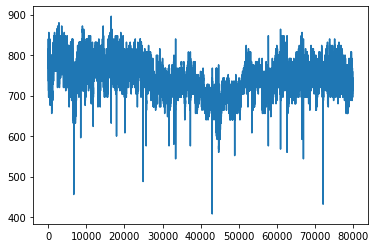

2016-01-02 07:12:23.540000
[784 784 784 ... 712 712 712]


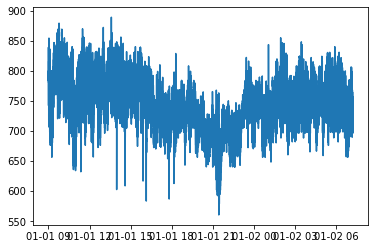

In [ ]:
# RRIデータを読み込み

import matplotlib.pyplot as plt
import sys
import datetime
import numpy as np
import read_rri


# name = '48hlt011.rri'
# name = '48hlt012.rri'
# name = '48hlt021.rri'
# name = '48hlt022.rri'
name = 'SV01a.24h'
# name = 'SV02a.24h'
# name = 'SV03a.24h'
# name = 'NS01a.24h'
# name = 'NS23a.24h'
# name = 'gauss01.rri'
# name = 'gauss_H19.rri'
# name = 'gauss_H32.rri'


RRI_max = 1500
RRI_min = 350
RRI_diff = 150
dt = 0.5   # second

t_resamp, RRI_resamp = read_rri.read_RRI(name, RRI_max, RRI_min, RRI_diff, dt)


   time   data
0   0.0  784.0
1   0.5  784.0
2   1.0  784.0
3   1.5  784.0
4   2.0  784.0
   time   data     MA
0   0.0  784.0  784.0
1   0.5  784.0  784.0
2   1.0  784.0  784.0
3   1.5  784.0  784.0
4   2.0  784.0  784.0


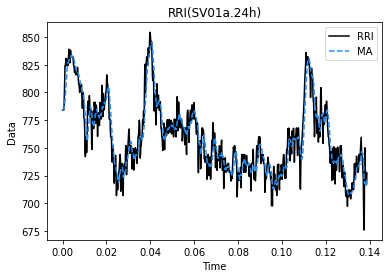

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

# dlen = len(t_resamp) # データの長さ
dlen = 1000
time_RRI = list(range(0, dlen))  # list型
time_RRI = np.asarray(time_RRI) * dt
RRI = RRI_resamp.tolist()  # list型
# ma_num = 1000   # 移動平均を求めるときに使用するデータ数
ma_num = int(dlen / 100)

# 移動平均（ma)を求める
df = pd.DataFrame({
    'time' : time_RRI,
    'data' : RRI[:dlen]
})
print(df.head())
df['MA'] = df['data'].rolling(window=ma_num, min_periods=0).mean()
print(df.head())

fig1 = plt.figure()
plt.title('RRI(%s)' % name)
plt.xlabel('Time')
plt.ylabel('Data')
# plt.plot(df['time'], df['data'], color = 'black', linestyle = '-', label = 'data2')
# plt.plot(df['time'], df['MA'], color = 'dodgerblue', linestyle = '--', label = 'MA')
plt.plot(df['time'] / 60**2, df['data'], color = 'black', linestyle = '-', label = 'RRI')
plt.plot(df['time'] / 60**2, df['MA'], color = 'dodgerblue', linestyle = '--', label = 'MA')
plt.legend()
plt.show()
fig1.savefig('%s img1.png' % name)

トレンド除去（Savitky-golay filter）

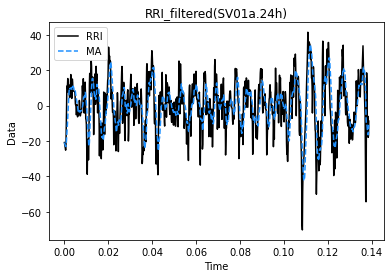

In [ ]:
# Savitky-golay filter

from scipy import signal

def detrend_savitky(df):
  scale = 103
  sg_return = signal.savgol_filter(x=df,
                                 window_length=scale,
                                 polyorder=2,
                                 deriv=0)
  m = df - pd.Series(sg_return)
  return m

df['data'] = detrend_savitky(df['data'])
df['MA'] = df['data'].rolling(window=ma_num, min_periods=0).mean()

plt.title('RRI_filtered(%s)' % name)
plt.xlabel('Time')
plt.ylabel('Data')
plt.plot(df['time'] / 60**2, df['data'], color = 'black', linestyle = '-', label = 'RRI')
plt.plot(df['time'] / 60**2, df['MA'], color = 'dodgerblue', linestyle = '--', label = 'MA')
plt.legend()
plt.show()

In [ ]:
# 標準化
ma = df['MA'].values.reshape(-1,1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)

# ma_num個のデータの移動平均を入力値として、次の点での移動平均を予測
data = []    # 入力データ
label = []    # 出力データ
for i in range(len(ma_std) - ma_num):
  data.append(ma_std[i : i + ma_num])   # append : データを加える
  label.append(ma_std[i + ma_num])
# ndarrayに変換
data = np.array(data)
label = np.array(label)
print("data size: {}". format(data.shape))
print("label size: {}". format(label.shape))

# 訓練データとテストデータのサイズを決定（ホールドアウト法）
test_len = int(dlen / 8)   # 128
train_len = int(data.shape[0] - test_len)
# 訓練データの準備
train_data = data[:train_len]
train_label = label[:train_len]
# テストデータの準備
test_data = data[train_len:]
test_label = label[train_len:]
# データの形状を確認
print("train_data size: {}". format(train_data.shape))
print("test_data size: {}". format(test_data.shape))
print("train_label size: {}". format(train_label.shape))
print("test_label size: {}". format(test_label.shape))

# ndarrayをPytorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# DataLoaderを使って、データセットを128個のミニパッチに分ける
# ミニパッチサイズを指定したデータローダを作成
train_batch = DataLoader(
    dataset = train_dataset,   # データセットの指定
    batch_size = 128,   # バッチサイズの指定
    shuffle = True,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

test_batch = DataLoader(
    dataset = test_dataset,   # データセットの指定
    batch_size = 128,   # バッチサイズの指定
    shuffle = False,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

# ミニバッチデータセットの確認
for data, label in train_batch:
  print("batch data size: {}". format(data.size()))  # バッチの入力データサイズ
  print("batch label size: {}". format(label.size()))   # バッチのラベルサイズ
  break


data size: (990, 10, 1)
label size: (990, 1)
train_data size: (865, 10, 1)
test_data size: (125, 10, 1)
train_label size: (865, 1)
test_label size: (125, 1)
batch data size: torch.Size([128, 10, 1])
batch label size: torch.Size([128, 1])


Device: cuda
-------------------------------------
Epoch: 1/50
Train_Loss : 8.25E-01 Test_Loss: 8.54E-01
-------------------------------------
Epoch: 2/50
Train_Loss : 5.65E-01 Test_Loss: 5.37E-01
-------------------------------------
Epoch: 3/50
Train_Loss : 3.82E-01 Test_Loss: 3.62E-01
-------------------------------------
Epoch: 4/50
Train_Loss : 2.42E-01 Test_Loss: 2.06E-01
-------------------------------------
Epoch: 5/50
Train_Loss : 1.33E-01 Test_Loss: 1.63E-01
-------------------------------------
Epoch: 6/50
Train_Loss : 1.18E-01 Test_Loss: 1.18E-01
-------------------------------------
Epoch: 7/50
Train_Loss : 9.89E-02 Test_Loss: 1.12E-01
-------------------------------------
Epoch: 8/50
Train_Loss : 8.46E-02 Test_Loss: 1.06E-01
-------------------------------------
Epoch: 9/50
Train_Loss : 7.51E-02 Test_Loss: 8.37E-02
-------------------------------------
Epoch: 10/50
Train_Loss : 6.77E-02 Test_Loss: 7.24E-02
-------------------------------------
Epoch: 11/50
Train_Loss : 6.

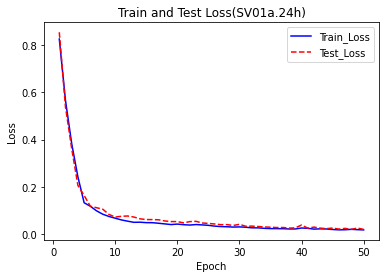

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    self.lstm = nn.LSTM(D_in, H, batch_first=True,
                        num_layers=1)
    self.linear = nn.Linear(H, D_out)
  
  def forward(self, x):
    output, (hidden, cell) = self.lstm(x)
    output = self.linear(output[:, -1, :])  # 最後のステップのみを入力
    return output

# ハイパーパラメータの定義
D_in = 1  # 入力次元：1
H = 200  # 隠れ層次元： 200
D_out = 1  # 出力次元： 1
epoch = 50  # 学習回数

# ネットワークのロード
# CPUとGPUのどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)
# デバイスの確認
print("Device: {}".format(device))

# 損失関数の定義
criterion = nn.MSELoss()  # 損失関数（平均二乗誤差：MSE）

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())


# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

# 学習（エポック）の実行
for i in range(epoch):
  # エポックの進行状況を表示
  print('-------------------------------------')
  print("Epoch: {}/{}".format(i+1,epoch))

  # 損失の初期化
  train_loss = 0  # 学習損失
  test_loss = 0  # 評価損失

  # ---学習パート--- #
  # ニューラルネットワークを学習モードに設定
  net.train()
  # ミニバッチごとにデータをロードし学習
  for data, label in train_batch:
    # GPUにTensorを転送
    data = data.to(device)
    label = label.to(device)

    # 勾配を初期化
    optimizer.zero_grad()
    # データを入力して予測値を計算（順伝搬）
    y_pred = net(data)
    # 損失（誤差）を計算
    loss = criterion(y_pred, label)
    # 勾配の計算（逆伝搬）
    loss.backward()
    # パラメータ（重み）の更新
    optimizer.step()
    # ミニバッチごとの損失を蓄積
    train_loss += loss.item()
  
  # ミニバッチの平均の損失を計算
  batch_train_loss = train_loss / len(train_batch)
  # ---学習パートはここまで--- #

  # ---評価パート--- #
  # ニューラルネットワークを評価モードに設定
  net.eval()
  # 評価時の計算で自動微分機能をオフにする
  with torch.no_grad():
    for data, label in test_batch:
      # GPUにTensorを転送
      data = data.to(device)
      label = label.to(device)
      # データを入力して予測値を計算（順伝搬）
      y_pred = net(data)
      # 損失（誤差）を計算
      loss = criterion(y_pred, label)
      # ミニバッチごとの損失を蓄積
      test_loss += loss.item()
    
  # ミニバッチの平均の損失を計算
  batch_test_loss = test_loss / len(test_batch)
  # ---評価パートはここまで--- #

  # エポックごとに損失を表示
  print("Train_Loss : {:.2E} Test_Loss: {:.2E}".format(
      batch_train_loss, batch_test_loss))
  # 損失をリスト化して保存
  train_loss_list.append(batch_train_loss)
  test_loss_list.append(batch_test_loss)


# 損失
fig2 = plt.figure()
plt.title('Train and Test Loss(%s)' % name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()
plt.show()
fig2.savefig('%s img2.png' % name)

MAE: 2.116


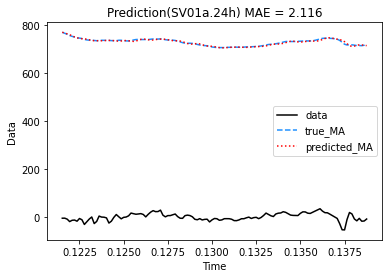

In [ ]:
# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
  # 初期化
  pred_ma = []
  true_ma = []
  for data, label in test_batch:
    # GPUにTensorを転送
    data = data.to(device)
    label = label.to(device)
    # データを入力して予測値を計算（順伝搬）
    y_pred = net(data)
    pred_ma.append(y_pred.view(-1).tolist())  # Tensorを1次元listに変換
    true_ma.append(label.view(-1).tolist())

# Tensorを数値データを取り出す
pred_ma = [elem for lst in pred_ma for elem in lst]  # listを1次元配列に
true_ma = [elem for lst in true_ma for elem in lst]  # listを1次元配列に

# 標準化を解除して元の株価に変換
pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

# 平均絶対誤差を計算
mae = mean_absolute_error(true_ma, pred_ma)
print("MAE: {:.3f}".format(mae))

# 終値と移動平均を図示する
time = df['time'][-1*test_len:] / 60**2  # テストデータの時間軸
test_close = df['data'][-1*test_len:].values.reshape(-1)  # テストデータの終値

fig3 = plt.figure()
plt.title('Prediction(%s) MAE = %.3f' % (name, mae))
plt.xlabel('Time')
plt.ylabel('Data')
plt.plot(time, test_close, color='black',
        linestyle='-', label='data')
plt.plot(time, true_ma, color='dodgerblue',
         linestyle='--', label='true_MA')
plt.plot(time, pred_ma, color='red',
         linestyle=':', label='predicted_MA')
plt.legend()
plt.show()
fig3.savefig('%s img3.png' % name)